<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_6_5_Keras_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original source https://github.com/zinsmatt/Neural-Network-Numpy/blob/master/neural-network.py

"""
Created on Thu Nov 15 20:42:52 2018
@author: matthieu
"""

In [ ]:
#@title Install DEAP
!pip install deap --quiet

     |████████████████████████████████| 160 kB 5.2 MB/s 


In [ ]:
#@title Imports
import tensorflow as tf
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
from IPython.display import clear_output

#DEAP
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

import random

11501568/11490434 [==============================] - 0s 0us/step
5


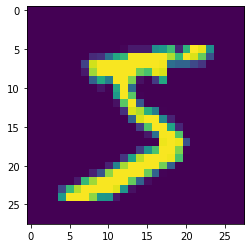

In [ ]:
#@title Dataset Parameters  { run: "auto" }
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X, Y = x_train / 255.0, y_train

plt.imshow(X[0])
print(Y[0])

In [ ]:
#@title Define Keras Model
middle_layer = 128 #@param {type:"slider", min:16, max:128, step:2}
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),  
  tf.keras.layers.Dense(middle_layer, activation='relu'),  
  tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
print(f"Trainable parameters: {trainableParams}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Trainable parameters: 101770


In [ ]:
def score_model():
  y_hat = model.predict(x_test)
  acc = [np.argmax(y)==y_test[i] for i,y in enumerate(y_hat)]
  return sum(acc)/len(acc)

def print_parameters():
  for layer in model.layers:
    for na in layer.get_weights():
      print(na)

def set_parameters(individual):
  idx = 0
  tensors=[]
  for layer in model.layers:
    for na in layer.get_weights():
      size = na.size
      sh = na.shape
      t = individual[idx:idx+size]
      t = np.array(t)
      t = np.reshape(t, sh)      
      idx += size
      tensors.append(t)
  model.set_weights(tensors)

individual = np.random.rand(trainableParams)
set_parameters(individual)
print(score_model())
print_parameters()

0.1007
[[0.9485753  0.26410663 0.53104275 ... 0.28235838 0.19210711 0.54314834]
 [0.3970142  0.23537366 0.70188135 ... 0.32557625 0.6643272  0.48917058]
 [0.4941955  0.1876921  0.1467511  ... 0.9167958  0.6112521  0.04076596]
 ...
 [0.96129775 0.94945186 0.32179555 ... 0.09880105 0.54414093 0.3357163 ]
 [0.843063   0.28031728 0.01271152 ... 0.00892823 0.37306225 0.8151725 ]
 [0.45052502 0.6076223  0.2383126  ... 0.47792426 0.76704955 0.40838167]]
[0.2700846  0.20085502 0.9688265  0.29116473 0.46633196 0.768128
 0.4468114  0.86172134 0.9711121  0.11119835 0.27446783 0.05390441
 0.11034027 0.9985136  0.9557695  0.04301693 0.9808005  0.0048623
 0.83901477 0.81843233 0.28281954 0.08967701 0.02914943 0.45840108
 0.5321872  0.5646644  0.90964556 0.57958585 0.22129275 0.32961395
 0.2819497  0.70949733 0.19234864 0.1406416  0.33904484 0.16420141
 0.32617828 0.9151462  0.942873   0.905798   0.9793749  0.39362612
 0.52927077 0.86979914 0.7207516  0.21082199 0.8681585  0.54201627
 0.6558783  0.09

In [ ]:
#@title Setting up the Creator
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [ ]:
#@title Create Individual and Population
def uniform(low, up, size=None):
  try:
    return [random.uniform(a, b) for a, b in zip(low, up)]
  except TypeError:
    return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox = base.Toolbox()
toolbox.register("attr_float", uniform, -1, 1, trainableParams)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selTournament, tournsize=5)

In [ ]:
def customBlend(ind1, ind2):
  for i, (x1, x2) in enumerate(zip(ind1, ind2)):        
        ind1[i] = (x1 + x2) / 2
        ind2[i] = (x1 + x2) / 2
  return ind1, ind2

#toolbox.register("mate", tools.cxBlend, alpha=.5)
toolbox.register("mate", customBlend)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=.1, indpb=.25)

In [ ]:
def evaluate(individual):  
  set_parameters(individual)
  print('.', end='')
  return 1./score_model(),   

toolbox.register("evaluate", evaluate)   

In [ ]:
#@title Optimize the Weights { run: "auto" }
MU = 25 #@param {type:"slider", min:5, max:1000, step:5}
NGEN = 1000 #@param {type:"slider", min:100, max:1000, step:10}
RGEN = 10 #@param {type:"slider", min:1, max:100, step:1}
CXPB = .6
MUTPB = .3

random.seed(64)

pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

Gen (7520)


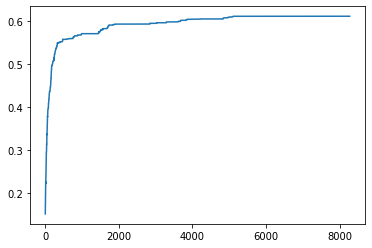

Best Neural Network accuracy :  0.6106
              precision    recall  f1-score   support

           0       0.18      0.00      0.00       980
           1       0.88      0.96      0.92      1135
           2       0.65      0.80      0.72      1032
           3       0.47      0.85      0.61      1010
           4       0.55      0.81      0.65       982
           5       0.35      0.05      0.08       892
           6       0.71      0.91      0.79       958
           7       0.50      0.00      0.01      1028
           8       0.58      0.81      0.68       974
           9       0.55      0.81      0.66      1009

    accuracy                           0.61     10000
   macro avg       0.54      0.60      0.51     10000
weighted avg       0.55      0.61      0.52     10000

...............................................................................................................................

In [ ]:
from sklearn.metrics import classification_report 
best = None
history = []

for g in range(NGEN):
  pop, logbook = algorithms.eaSimple(pop, toolbox, 
            cxpb=CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, halloffame=hof, verbose=False)
  best = hof[0] 

  clear_output()
  print(f"Gen ({(g+1)*RGEN})")    
  history.extend([1/l["min"] for l in logbook])
  plt.plot(history)
  plt.show()
  set_parameters(best)
  accuracy = score_model()
  print("Best Neural Network accuracy : ", accuracy)
  if accuracy > .99999: #stop condition
    break  
  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred, axis=1)   
  print(classification_report(y_test, y_pred))